# Evaluation
This notebook serves to showcase how the evaluation pipeline is performed. Full script can be found at `eval.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

import copy
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from src.causaldynamics.scm import create_scm_graph
from src.causaldynamics.plot import animate_3d_trajectories, plot_trajectories, plot_scm
from src.causaldynamics.score import score
from src.causaldynamics.baselines import PCMCIPlus, FPCMCI, VARLiNGAM, DYNOTEARS, NGC_LSTM, TSCI, CUTSPlus

from tqdm import tqdm
from pathlib import Path


Complete script to generate the dataset can be found under `scripts/generate_<system>.py`. 

Otherwise, follow our instructions to download and process the pre-generated dataset from https://huggingface.co/datasets/kausable/CausalDynamics

In [3]:
# Once you have the daatset (you can change this to your own path)
# Notice that the dataset has `time_series` and `adjacency_matrix` variables.

DATA_DIR = Path("../data/simplex/noise=0.00_confounder=False/data")

ds = xr.open_dataset(DATA_DIR / "Lorenz84_N10_T1000.nc")
ds 


<xarray.Dataset> Size: 128kB
Dimensions:           (dim_in: 3, dim_out: 3, time: 1000, system: 10, dim: 3)
Coordinates:
  * dim_in            (dim_in) int64 24B 0 1 2
  * dim_out           (dim_out) int64 24B 0 1 2
  * time              (time) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * system            (system) int64 80B 0 1 2 3 4 5 6 7 8 9
  * dim               (dim) int64 24B 0 1 2
Data variables:
    adjacency_matrix  (dim_in, dim_out) int64 72B ...
    time_series       (time, system, dim) float32 120kB ...

In [4]:
# Extract timeseries and adjacency matrix as target
## NOTE: similar to our current evaluation pipeline, for multidimension node
## we extract the first variable to mimic partially-observed / under-resolved dynamics prevalent in real-world settings

timeseries = ds['time_series'].to_numpy().transpose(1, 0, 2) # shape of (N, T, D)
adj_matrix = ds['adjacency_matrix'].to_numpy()


# Evaluation

Evaluate CUTS+

In [5]:
# CUTS+
tau_max = 1
corr_thres = 0.8

## Estimate adjacency matrix
cuts_adj_matrix = []
for x in tqdm(timeseries):
    cuts_model = CUTSPlus(tau_max=tau_max, corr_thres=corr_thres)
    cuts_model.run(X=x)
    cuts_adj_matrix.append(copy.deepcopy(cuts_model.adj_matrix))

## Compute scores
score(
    preds= np.array(cuts_adj_matrix),
    labs= adj_matrix,
    name='CUTS+'
)


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]

Scoring...


,CUTS+
Metric,
Joint AUROC,0.500000
Individual AUROC,0.500000
Null AUROC,0.500000
Joint AUPRC,0.666667
Individual AUPRC,0.666667
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([-0.99811642, -0.26940975]),
  1: array([ 0.77881683, -0.73059025]),
  2: array([0.21929959, 1.        ])})

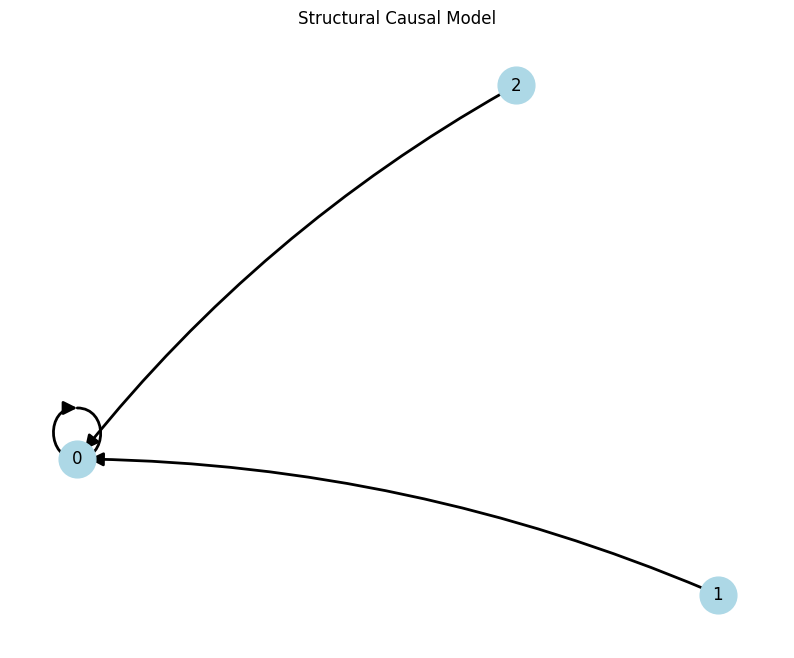

In [6]:
G = create_scm_graph(cuts_model.adj_matrix)
plot_scm(G)


Evaluate TSCI

In [7]:
# TSCI
tau_max = 1
corr_thres = 0.8

## Estimate adjacency matrix
tsci_adj_matrix = []
for x in tqdm(timeseries):
    tsci_model = TSCI(tau_max=tau_max, corr_thres=corr_thres)
    tsci_model.run(X=x)
    tsci_adj_matrix.append(copy.deepcopy(tsci_model.adj_matrix))

## Compute scores
score(
    preds= np.array(tsci_adj_matrix),
    labs= adj_matrix,
    name='TSCI'
)


  0%|                                                                            | 0/200 [00:00<?, ?it/s]
                                                                                                         
  0%|                                                                            | 0/200 [00:00<?, ?it/s]
                                                                                                         
  0%|                                                                            | 0/200 [00:00<?, ?it/s]
                                                                                                         
  0%|                                                                            | 0/200 [00:00<?, ?it/s]
                                                                                                         
  0%|                                                                            | 0/200 [00:00<?, ?it/s]
                                              

Scoring...


,TSCI
Metric,
Joint AUROC,0.533333
Individual AUROC,0.533333
Null AUROC,0.500000
Joint AUPRC,0.682667
Individual AUPRC,0.695833
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([ 0.76678274, -0.54818152]),
  1: array([0.06956444, 1.        ]),
  2: array([-0.83634718, -0.45181848])})

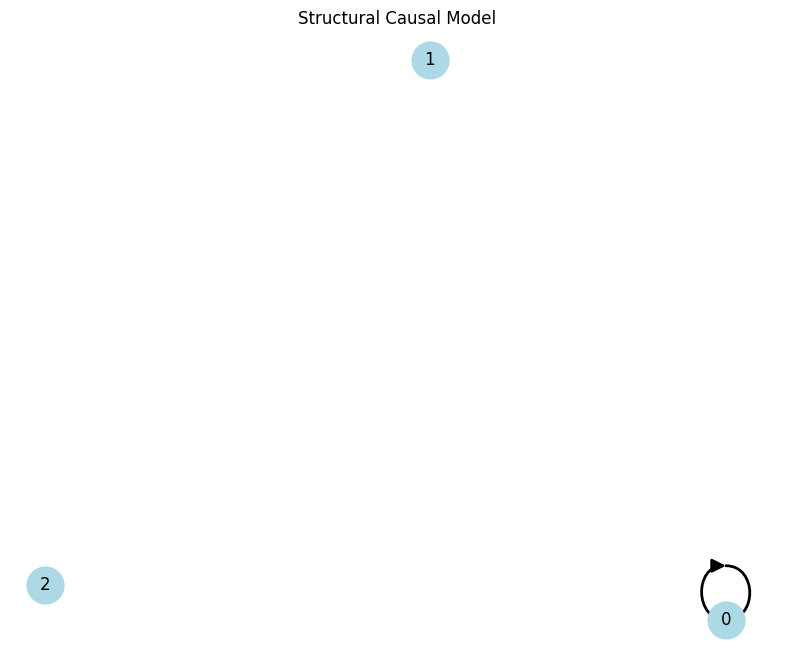

In [8]:
G = create_scm_graph(tsci_model.adj_matrix)
plot_scm(G)


Evaluate PCMCI+

In [9]:
# PCMCI+
tau_max = 1
pc_alpha = 0.05

## Estimate adjacency matrix
pcmci_plus_adj_matrix = []
for x in tqdm(timeseries):
    pcmciplus_model = PCMCIPlus(tau_max=tau_max, pc_alpha=pc_alpha)
    pcmciplus_model.run(X=x)
    pcmci_plus_adj_matrix.append(copy.deepcopy(pcmciplus_model.adj_matrix))

## Compute scores
score(
    preds= np.array(pcmci_plus_adj_matrix),
    labs= adj_matrix,
    name='PCMCI+'
)


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.61it/s]

Scoring...


,PCMCI+
Metric,
Joint AUROC,0.433333
Individual AUROC,0.433333
Null AUROC,0.500000
Joint AUPRC,0.638482
Individual AUPRC,0.638889
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([-0.2767556,  1.       ]),
  1: array([ 0.90337046, -0.47463232]),
  2: array([-0.62661486, -0.52536768])})

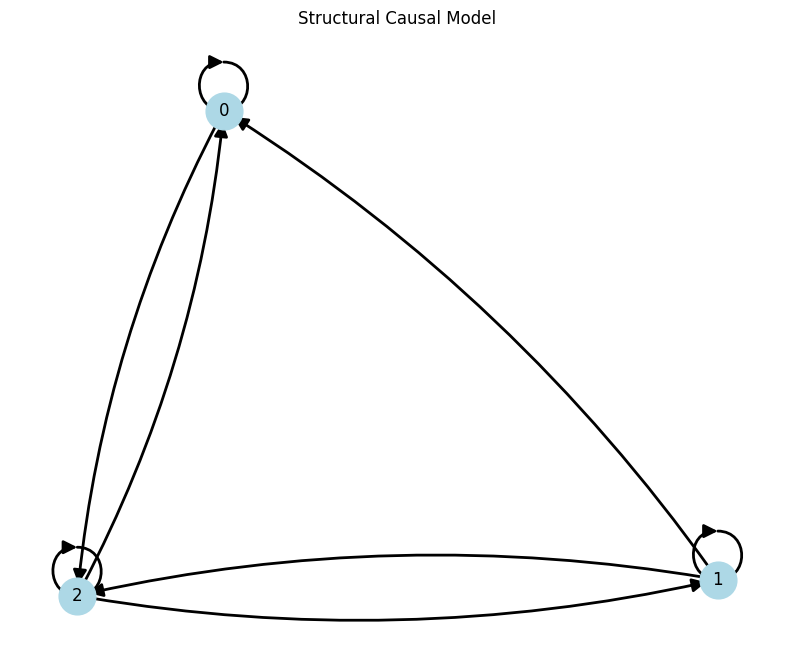

In [10]:
G = create_scm_graph(pcmciplus_model.adj_matrix)
plot_scm(G)


Evaluate F-PCMCI

In [11]:
# FPCMCI
tau_max = 1
pc_alpha = 0.05

## Estimate adjacency matrix
fpcmci_adj_matrix = []
for x in tqdm(timeseries):
    fpcmci_model = FPCMCI(tau_max=tau_max, pc_alpha=pc_alpha)
    fpcmci_model.run(X=x)
    fpcmci_adj_matrix.append(copy.deepcopy(fpcmci_model.adj_matrix))

## Compute scores
score(
    preds= np.array(fpcmci_adj_matrix),
    labs= adj_matrix,
    name='F-PCMCI'
)


  0%|                                                                             | 0/10 [00:00<?, ?it/s]  File "/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/IDTxl/idtxl/estimators_opencl.py", line 9, in <module>
    import pyopencl as cl
  File "/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/IDTxl/idtxl/synergy_tartu.py", line 33, in <module>
    import ecos
  File "/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/IDTxl/idtxl/pid_goettingen.py", line 8, in <module>
    from prettytable import PrettyTable
  File "/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/IDTxl/idtxl/estimators_mpi.py", line 11, in <module>
    from mpi4py.futures import MPIPoolExecutor

    Error importing Cython fast embedding module for HDE estimator.
    When running the HDE estimator, the slow Python implementation for optimizing the HDE embedding will be used,
    this may take a long time. Other estimators are

Scoring...


,F-PCMCI
Metric,
Joint AUROC,0.550000
Individual AUROC,0.550000
Null AUROC,0.500000
Joint AUPRC,0.689655
Individual AUPRC,0.691667
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([ 1.        , -0.18049081]),
  1: array([-0.65630963, -0.77578   ]),
  2: array([-0.34369037,  0.95627081])})

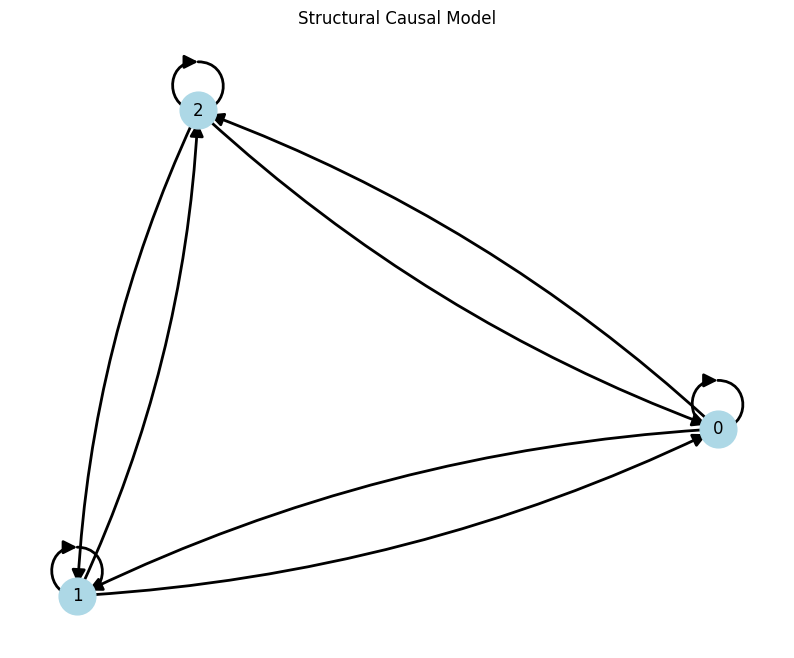

In [12]:
G = create_scm_graph(fpcmci_model.adj_matrix)
plot_scm(G)


Evaluate VARLiNGAM

In [13]:
# VARLiNGAM
tau_max = 1

## Estimate adjacency matrix
varlingam_adj_matrix = []
for x in tqdm(timeseries):
    varlingam_model = VARLiNGAM(tau_max=tau_max)
    varlingam_model.run(X=x)
    varlingam_adj_matrix.append(copy.deepcopy(varlingam_model.adj_matrix))

## Compute scores
score(
    preds= np.array(varlingam_adj_matrix),
    labs= adj_matrix,
    name='VARLiNGAM'
)


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.10it/s]

Scoring...


,VARLiNGAM
Metric,
Joint AUROC,0.575000
Individual AUROC,0.575000
Null AUROC,0.500000
Joint AUPRC,0.701786
Individual AUPRC,0.704861
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([-0.36390604, -0.94459929]),
  1: array([1.        , 0.15714777]),
  2: array([-0.63609396,  0.78745152])})

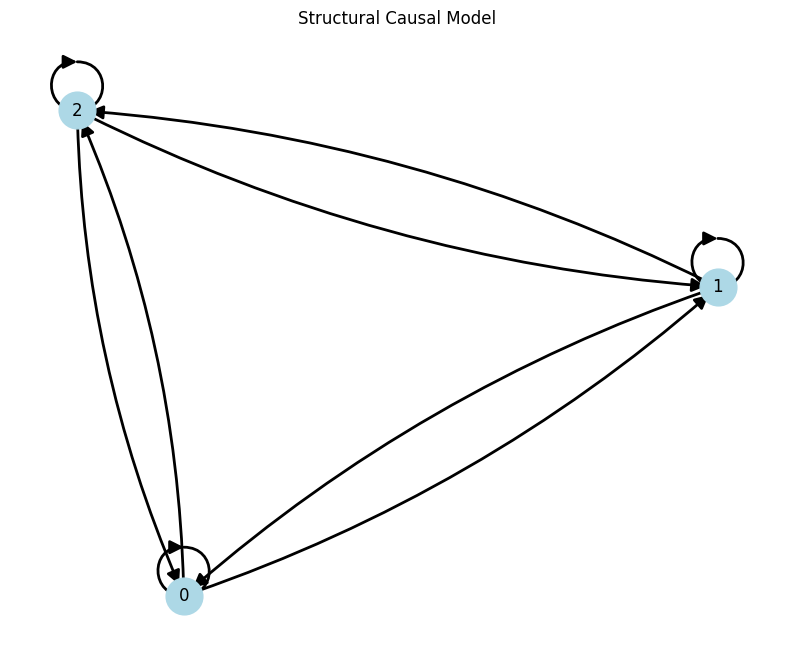

In [14]:
G = create_scm_graph(varlingam_model.adj_matrix)
plot_scm(G)


Evaluate DYNOTEARS

In [15]:
# DYNOTEARS
tau_max = 1

## Estimate adjacency matrix
dynotears_adj_matrix = []
for x in tqdm(timeseries):
    dynotears_model = DYNOTEARS(tau_max=tau_max)
    dynotears_model.run(X=x)
    dynotears_adj_matrix.append(copy.deepcopy(dynotears_model.adj_matrix))

## Compute scores
score(
    preds= np.array(dynotears_adj_matrix),
    labs= adj_matrix,
    name='DYNOTEARS'
)


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.95it/s]

Scoring...


,DYNOTEARS
Metric,
Joint AUROC,0.508333
Individual AUROC,0.508333
Null AUROC,0.500000
Joint AUPRC,0.670401
Individual AUPRC,0.670635
Null AUPRC,0.666667


(<Axes: title={'center': 'Structural Causal Model'}>,
 {0: array([ 0.73233556, -1.        ]),
  1: array([-0.89454797,  0.68175438]),
  2: array([0.16221241, 0.31824562])})

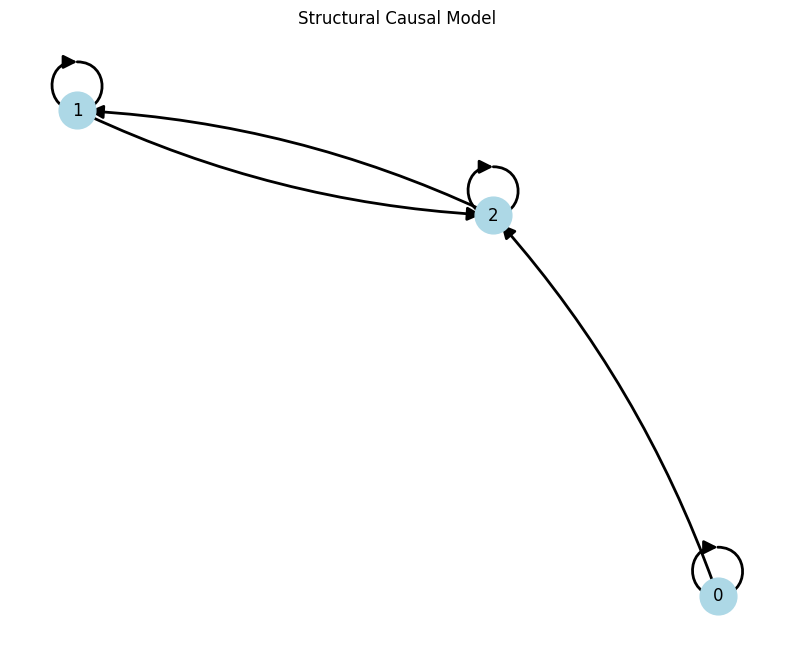

In [16]:
G = create_scm_graph(dynotears_model.adj_matrix)
plot_scm(G)


Evaluate NeuralGC (cLSTM)

In [ ]:
# cLSTM
tau_max = 1

## Estimate adjacency matrix
clstm_adj_matrix = []
for x in tqdm(timeseries):
    clstm_model = NGC_LSTM(tau_max=tau_max)
    clstm_model.run(X=x)
    clstm_adj_matrix.append(copy.deepcopy(clstm_model.adj_matrix))

## Compute scores
score(
    preds= np.array(clstm_adj_matrix),
    labs= adj_matrix,
    name='cLSTM'
)


 60%|█████████████████████████████████████████▍                           | 6/10 [00:04<00:02,  1.55it/s]

In [ ]:
G = create_scm_graph(clstm_model.adj_matrix)
plot_scm(G)
